# Spanish End-To-End Automatic Speech Recognition

In this notebook we finetune an English acoustic model with Spanish data to create a SOTA Spanish ASR model to exemplify the process of creating high-performing ASR models for your use-case. Specifically, we fine-tune a pre-trained English ASR model with `Spanish` open source dataset from `Common Voice`. [Common Voice](https://voice.mozilla.org/en/datasets) is a multi-language dataset of voices that anyone can use to train speech-enabled applications.

ASR or Automatic Speech Recognition solves the problem of automatically transcribing spoken language i.e. Speech-to-Text. The goal is to have a model that minimizes the Word Error Rate(WER) metric when transcribing speech input. In other words, given some audio file (e.g. a WAV file) containing speech, how do we transform this into the corresponding text with as few errors as possible?

Current State of the Art Automatic Speech Recognition systems are based on `End-to-End Architecture` where we directly learn `p(transcript|audio)`. These models simply take an audio input and give a textual output, and in which all components of the architecture are trained together towards the same goal. The model's encoder would be akin to an acoustic model for extracting speech features, which can then be directly piped to a decoder which outputs text.

Steps followed in this notebook to create high-performing Spanish language ASR model:
1. [Dataset Download](#data_download)
2. [Dataset Exploration](#data_exploration)
3. [Dataset Preparation](#data_preparation)
4. [Dataset Exploration in Depth](#data_depth)
5. [Training](#training)
6. [Transfer Learning and Finetuning](#finetuning)
7. [Performance Comparison](#comparison)


In [5]:
import os

# APP directory
if os.environ.get("APP_DIR") == None:
    os.environ["APP_DIR"] = "/nemo_asr_app"
app_dir = os.environ.get("APP_DIR")

# Data directory for datasets and results
if os.environ.get("DATA_DIR") == None:
    os.environ["DATA_DIR"] = "/data/asr/"
data_dir = os.environ.get("DATA_DIR")
print("APP DIR:", app_dir,"DATA DIR:", data_dir)

APP DIR: /home/ssahu/nemo_asr_app DATA DIR: /data/asr


In [6]:
import numpy as np
import pandas as pd
import subprocess
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd
from IPython.core.display import display, HTML
from tools.System.config import cfg
from tools.System.reader import Reader
from tools.filetools import file_exists
from tools.misc import create_lm_dataset, parse_manifest_wer, barplot_manifest
#from tools.NeMo.demo_inference import offline_inference
from tools.misc import show_diff
#from nemo.collections.asr.helpers import word_error_rate

<a id='data_download'></a>
# 1. Dataset Download

Download the `SPANISH` dataset from: https://voice.mozilla.org/en/datasets

After adding your information copy the download link (right-click) and use the bash commands below to download and extract the data. We recommend running these commands in the container's terminal.

```bash
mkdir /data/asr/MCV_ES
cd /data/asr/MCV_ES
wget [download link]
tar xzf es.tar.gz
```

In [7]:
#!mkdir /data/asr/MCV_ES

In [8]:
#!wget -P /data/asr/MCV_ES https://cdn.commonvoice.mozilla.org/cv-corpus-5.1-2020-06-22/es.tar.gz

In [9]:
#!cd /data/asr/MCV_ES/ && tar xzf es.tar.gz

<a id='data_exploration'></a>
# 2. Dataset Exploration

Let's take a look at our Data. Common Voice Datasets is an open source, multi-language dataset of voices that anyone can use to train speech-enabled applications. The spanish datset contains about `521` hours of `mp3` audio clips containing `18,906` voices.

The dataset contains a folder `clips` with the `mp3` audio clips and `.tsv` files separated in different splits. Each corpus contains `invalidated` and `validated` data, where the validated data is used to create the `train`, `dev` and `test` datasets. The split of `valid.tsv` into `train.tsv`, `dev.tsv`, and `test.tsv` is done such that the number of clips in `dev.tsv` or `test.tsv` is a "statistically significant" sample relative to the number of clips in` train.tsv`. To learn more, see this [link](https://github.com/mozilla/CorporaCreator#usage).

In [14]:
# path to MCV dataset directory
path = os.path.join(os.environ['DATA_DIR'],"MCV_ES","cv-corpus-5.1-2020-06-22","es") 
print(path)

/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es


In [10]:
import librosa
# Load and listen to the audio file
audio_file = os.path.join(os.environ['APP_DIR'],"example_audios", "es_example1.wav")
truth = ["el siguiente diagrama muestra a las localidades más próximas a monterey"]
audio, sample_rate = librosa.load(audio_file)

ipd.Audio(audio_file, rate=sample_rate)

In an ASR task, if this WAV file was our input, then "el siguiente diagrama muestra a las localidades más próximas a monterey" would be our desired transcription output.

Let's plot the waveform, which is simply a line plot of the sequence of values that we read from the file. This is a format of viewing audio that you are likely to be familiar with seeing in many audio editors and visualizers.

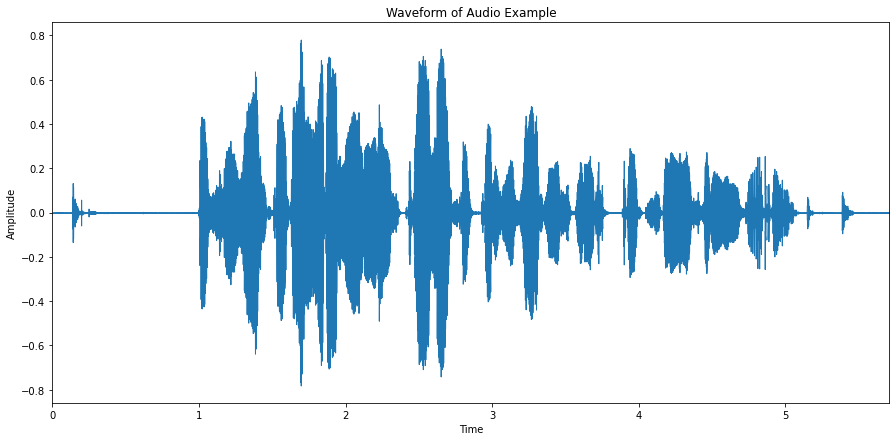

In [11]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveplot(audio)

We can see the activity in the waveform corresponding to each word utterance in the sentence.

Audio information is more useful in the context of frequencies of sound over time, we can get a better representation than this raw sequence of 57,330 values. We can apply a Fourier Transform on our audio signal to get something more useful: a `spectrogram`, which is a representation of the energy levels (i.e. amplitude, or "loudness") of each frequency (i.e. pitch) of the signal over the duration of the file. A spectrogram (which can be viewed as a heat map) is a good way of seeing how the strengths of various frequencies in the audio vary over time, and is obtained by breaking up the signal into smaller, usually overlapping chunks and performing a Short-Time Fourier Transform (STFT) on each.

Let's examine what the spectrogram of our sample looks like.

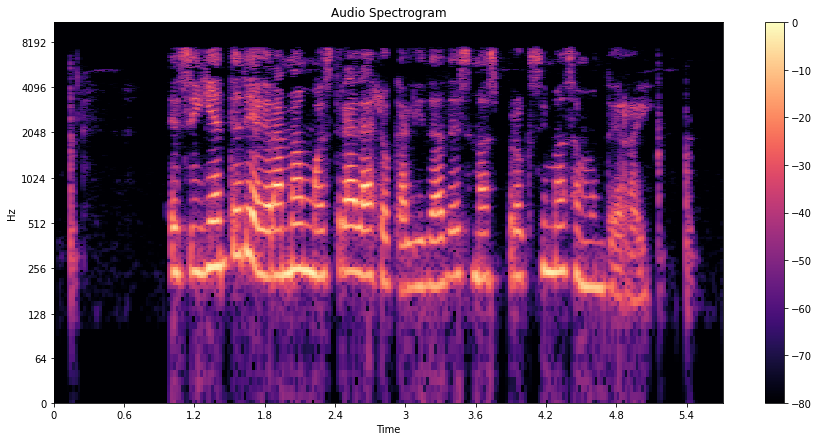

In [12]:
# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

However, audio features that help transcribe human speech are best captured in `Mel Spectogram` that incorporates a change in frequency scale that we use from linear (or logarithmic) to the `mel scale`. It transforms frequencies to align more to human perception.

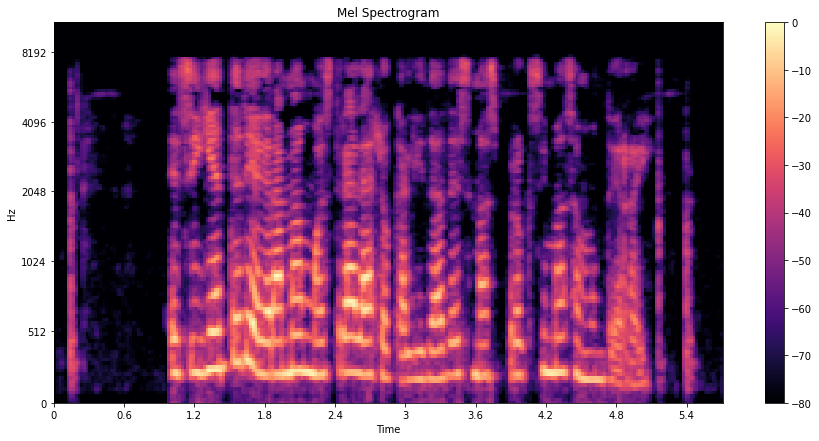

In [13]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

<a id='data_preparation'></a>
# 3. Dataset Preparation

## Text and Audio Formatting
To format the text and audio files to create a NeMo dataset we will use the script `/tools/NeMo/create_datasets/create_common_voice_dataset_ES.py`. To better understand this script and our data, we show the text formatting functions used by the script.

To train NeMo, our transcripts need to be normalized as follows:

- Normalize text: lowercase text, remove punctuation, change digits to text e.g. 3 to "three" or "tres" for Spanish
- Confirm we only use valid characters from our specified vocabulary.

*Note: When doing cross-lingual ASR your vocabulary size will be different from the English vocabulary.*

In [7]:
import pandas as pd
import unidecode
# TO RUN: python3 convert_tsv_to_manifest_ru.py [train|dev]

# Normalize text to only include valid characters
def normalize_str(txt) -> str:
    invalids = set()
    #vocabulary
    valid_chars = (" ", "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s",
                   "t", "u", "v", "w", "x", "y", "z", "'", 
                   "á", "é", "í", "ó", "ú", "ñ", "ü") # New Spanish Valid Characters
    #lowercase
    new_txt = txt.lower().strip()
    
    # no digits exist in MCV_ES dataset -if your dataset has digits you can use num2words, available in our transcript_tools.py script
    
    # Remove characters not in vocabulary
    res_arr = []
    for c in new_txt:
        if c in valid_chars:
            res_arr.append(c)
        else:
            # remove accent and see if it is valid
            non_accent_c = unidecode.unidecode(c)
            if non_accent_c in valid_chars:
                res_arr.append(non_accent_c)
            # a character we don't know
            else:
                invalids.update(c)
                res_arr.append(' ')
    res = ''.join(res_arr).strip()
    return ' '.join(res.split()), invalids

# Text Formatting
def tsv_to_manifest(tsv_files):
    manifests = []
    uniq_all = set()
    invalid_all = set()
    for tsv_file in tsv_files:
        print('Processing: {0}'.format(tsv_file))
        dt = pd.read_csv(tsv_file, sep='\t', encoding='utf8')
        for index, row in dt.iterrows():
            try:
                entry = {}
                entry['text'], invalids = normalize_str(row['sentence'])
                uniq = set(entry['text'])
                uniq_all.update(uniq)
                invalid_all.update(invalids)
                manifests.append(entry)
            except:
                print("SOMETHING WENT WRONG - IGNORING ENTRY")
    print('Done!')
    return manifests, uniq_all, invalid_all

In [8]:
tsv_file = "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/dev.tsv"
# manifest_file = "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/dev_manifest.json"
manifest, unique, invalid = tsv_to_manifest([tsv_file])

Processing: /data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/dev.tsv
Done!


In [9]:
print(len(unique))
print(unique)

35
{'c', 'b', 't', 'í', 'f', 'u', "'", 'w', 'j', 'e', 'i', 'g', 'o', 'h', 'é', 'v', 'p', 'z', 'y', 'm', 'x', 'r', ' ', 'á', 'ú', 's', 'ó', 'q', 'ü', 'a', 'k', 'ñ', 'n', 'd', 'l'}


In [11]:
#invalid characters
print(len(invalid))
print(invalid)

23
{'.', '"', '¿', 'œ', '—', '=', '毵', '蝦', ',', '”', '!', '“', '–', '…', '¡', '?', ';', ':', '_', '-', '夷', '{', 'ا'}


In [12]:
#manifest examples
manifest[0:5]

[{'text': 'entonces el matrimonio se vino abajo y hace cuatro años están separados'},
 {'text': 'con el tiempo la saya pasó a designar únicamente la falda'},
 {'text': 'además ha impartido conferencias tanto en extremadura como fuera de ella'},
 {'text': 'es importante consultar siempre ya que no es un descuento obligatorio'},
 {'text': 'escribió novelas relatos y biografías'}]

## Create NEMO Dataset

We will be preparing the train, test and dev data manifests from MCV_ES in this notebook containing metadata of our audio files. If you use a different language make sure to edit the vocabulary in the dataset parsing script.

NeMo data sets take in a standardized manifest format where each line corresponds to one sample of audio, such that the number of lines in a manifest is equal to the number of samples that are represented by that manifest. A line must contain the path to an audio file, the corresponding transcript (or path to a transcript file), and the duration of the audio sample.

Here's an example of what one line in a NeMo-compatible manifest might look like:
```
{"audio_filepath": "path/to/audio.wav", "duration": 3.45, "text": "this is a nemo tutorial"}
```
To create the datasets you have to run the commands generated in the terminal (the data processing can take some time).

In [21]:
tsvs = "train.tsv" # tsv filename to convert (must exist within path provided)
output = "train.json" # filename for dataset

cmd = "! python {}/create_datasets/create_common_voice_dataset_ES.py --path={} --tsv_files={} --output={}".format(cfg.NEMO.TOOLS, path, tsvs, output)
print(cmd)

! python /home/ssahu/nemo_asr_app/tools/NeMo/create_datasets/create_common_voice_dataset_ES.py --path=/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es --tsv_files=train.tsv --output=train.json


In [22]:
tsvs = "dev.tsv" # tsv filename to convert (must exist within path provided)
output = "dev.json" # filename for dataset

cmd = "! python {}/create_datasets/create_common_voice_dataset_ES.py --path={} --tsv_files={} --output={}".format(cfg.NEMO.TOOLS, path, tsvs, output)
print(cmd)

! python /home/ssahu/nemo_asr_app/tools/NeMo/create_datasets/create_common_voice_dataset_ES.py --path=/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es --tsv_files=dev.tsv --output=dev.json


In [23]:
tsvs = "test.tsv" # tsv filename to convert (must exist within path provided)
output = "test.json" # filename for dataset

cmd = "! python {}/create_datasets/create_common_voice_dataset_ES.py --path={} --tsv_files={} --output={}".format(cfg.NEMO.TOOLS, path, tsvs, output)
print(cmd)

! python /home/ssahu/nemo_asr_app/tools/NeMo/create_datasets/create_common_voice_dataset_ES.py --path=/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es --tsv_files=test.tsv --output=test.json


In [15]:
#! python /home/ssahu/nemo_asr_app/tools/NeMo/create_datasets/create_common_voice_dataset_ES.py --path=/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/ --tsv_files=dev.tsv --output=dev.json

In [24]:
!head -n5 /data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/dev.json

{"audio_filepath": "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20067219.wav", "duration": 5.76, "text": "entonces el matrimonio se vino abajo y hace cuatro años están separados"}
{"audio_filepath": "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20067220.wav", "duration": 5.04, "text": "con el tiempo la saya pasó a designar únicamente la falda"}
{"audio_filepath": "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20067221.wav", "duration": 5.952, "text": "además ha impartido conferencias tanto en extremadura como fuera de ella"}
{"audio_filepath": "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20067218.wav", "duration": 5.16, "text": "es importante consultar siempre ya que no es un descuento obligatorio"}
{"audio_filepath": "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20067217.wav", "duration": 4.44, "text": "escribió novelas relatos y biografías"}


<a id='data_depth'></a>
# 4. Dataset Exploration in Depth

Prior to training it's important to explore the quality of the dataset. Next, we confirm that our dataset contains only the valid characters, understand the distribution of the audio durations and randomly explore utterances.

### Confirm Valid Characters in generated datasets

In [26]:
import json
train_d = os.path.join(path,"train.json")
dev_d = os.path.join(path,"dev.json")

dev = []
with open(dev_d, "r") as a_file:
    for line in a_file:
        dev.append(json.loads(line))            
    
train = []
with open(train_d, "r") as a_file:
    for line in a_file:
        train.append(json.loads(line))

In [27]:
def uniques_c(lines, unique_all):
    for ix in range(len(lines)):
        uniq = set(lines[ix]['text'])
        uniq_all.update(uniq)

In [29]:
uniq_all = set()
uniques_c(dev, uniq_all) # dev
uniques_c(train, uniq_all) # train

In [30]:
print(len(uniq_all))
print(uniq_all)

35
{'k', 'v', 'l', 't', "'", 'e', 'f', 'c', 'p', 'ú', 'o', 'q', 'n', 'i', 'ü', 'd', 's', 'u', 'w', 'z', 'b', ' ', 'a', 'g', 'ó', 'ñ', 'x', 'í', 'á', 'é', 'h', 'j', 'm', 'r', 'y'}


## Exploring Dataset Duration and Quality

In [31]:
explore = dev
#explore = train

### Audio Durations

Min: 1.632 , Max: 11.136 , Mean: 6.014540511440107 , Total(hrs):  24.826686666666667


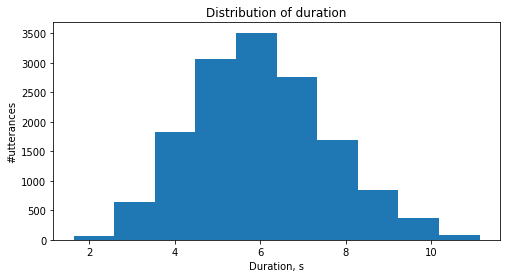

In [32]:
import matplotlib.pyplot as plt

durations = [explore[idx]['duration'] for idx in range(len(explore))]
plt.figure(figsize=[8,4])
plt.hist(durations)
plt.title('Distribution of duration')
plt.xlabel('Duration, s')
plt.ylabel('#utterances')
print("Min:",np.min(durations),", Max:",np.max(durations), ", Mean:",np.mean(durations),", Total(hrs): ", np.sum(durations)/3600)

### Word Distributions

Number of utterances: 14860


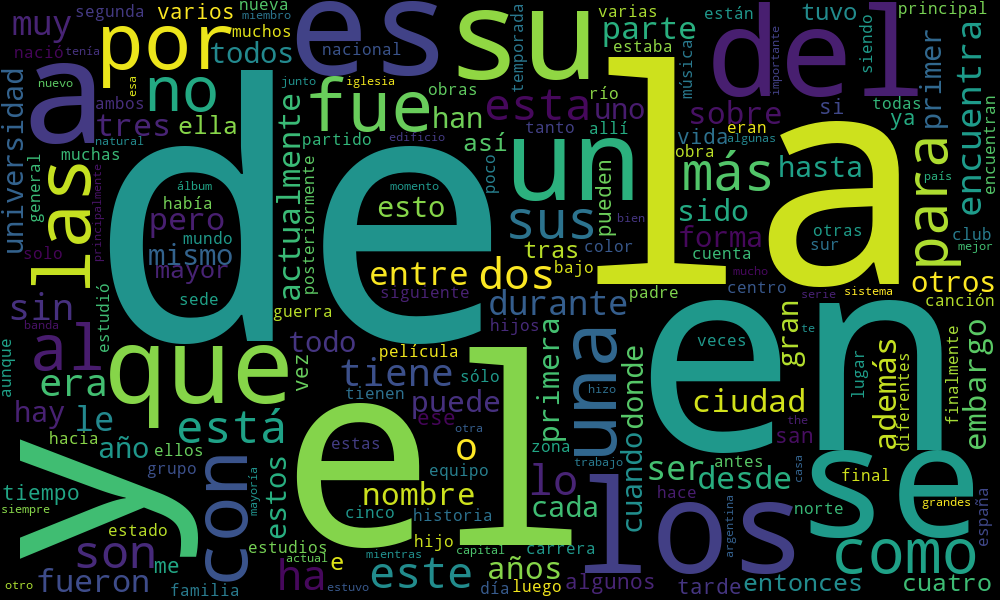

In [33]:
import wordcloud
from collections import defaultdict, Counter

texts = [explore[idx]['text'] for idx in range(len(explore))]
print(f'Number of utterances: {len(texts)}')
counter = Counter(' '.join(texts).split())
wc = wordcloud.WordCloud(width=1000, height=600)
wc.generate_from_frequencies(counter)
wc.to_image()

### Top N Words

In [34]:
N = 20
words = {}
for word, count in counter.most_common(N):   
    words[word] = {}
    words[word]['count'] = count
    words[word]['indices'] = []
    for idx in range(len(texts)):
        if word in texts[idx].split():
            words[word]['indices'].append(idx)
            
for w in words:
    print(f'{w}, {words[w]["count"]}')

de, 8880
la, 5974
en, 5027
el, 4463
y, 3432
se, 2651
a, 2276
es, 1957
los, 1949
su, 1846
del, 1794
un, 1492
que, 1410
por, 1409
una, 1368
las, 1320
con, 1271
fue, 1115
al, 871
no, 830


### Explore utterance information

In [35]:
from IPython.display import Audio, display

def display_utterance(idx):    
    text =  explore[idx]['text']
    filename = explore[idx]['audio_filepath']
    dur = explore[ind]['duration']
    print('Filename: {}'.format(filename))
    audio, fs = librosa.load(filename, sr=None)
    
    print('Sample rate: {} Hz'.format(fs))
    print('Transcript: {}'.format(text))
    print('Duration: {} s'.format(dur))

    ipd.Audio(explore[idx]['audio_filepath']) # audio playback
    
    display(Audio(data=audio, rate=fs))
    
    plt.figure(figsize=[15, 10], facecolor='white')
    
    plt.subplot('211')
    plt.plot(np.arange(audio.shape[0])/fs, audio, color='green')
    plt.xlabel('Time, s')
    plt.title('Audio signal')
    plt.grid()
    
    plt.subplot('212')
    win_length = int(fs*0.02)
    hop_length = int(fs*0.01)
    n_fft = 512  # 2 ** math.ceil(math.log2(win_length))

    '''
    # mel scale spectrogram
    S = librosa.feature.melspectrogram(y=audio, sr=fs,
                                       n_fft=n_fft,
                                       hop_length=hop_length,
                                       n_mels=80)
    '''
    # linear scale spectrogram
    S = librosa.stft(y=audio,
                     n_fft=n_fft,
                     hop_length=hop_length)
    
    S_dB = librosa.power_to_db(np.abs(S)**2, ref=np.max, top_db=120)
    plt.imshow(S_dB[::-1,], aspect='auto')
    
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.axis('off')

Filename: /data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_19620558.wav
Sample rate: 16000 Hz
Transcript: y así lo hizo
Duration: 3.768 s


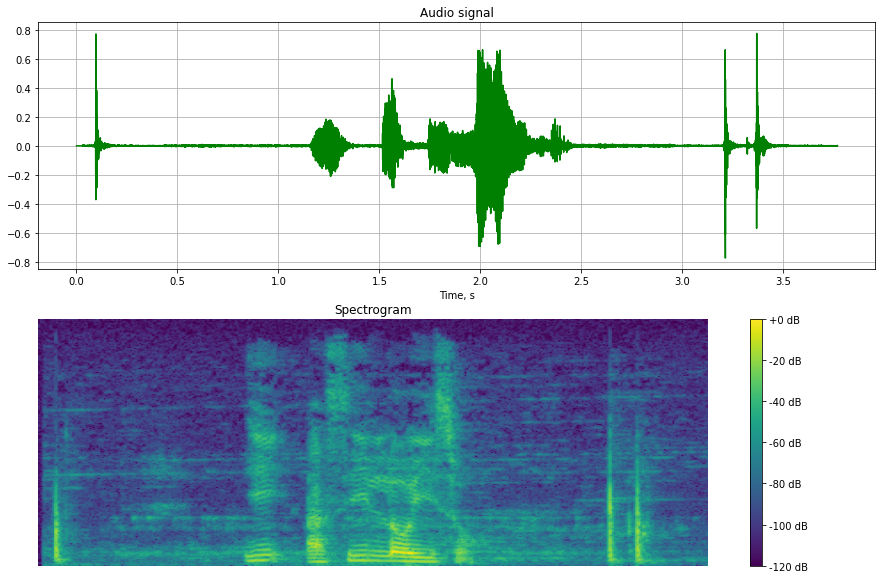

In [36]:
# Select a random entry to listen to the audio and confirm the transcription
import random
ind = random.randint(0, len(explore))
display_utterance(ind)

<a id='training'></a>
# 5. Training

We can train an ASR model for our use-case from **scratch** or **finetune** a pre-trained model. Given the limited available data for Automatic Speech Recognition which consists of many hours of transcribed audios, finetuning achieves a better performance than training from scratch. This is because previous knowledge (even from different language) is useful. We will see this in our use case where we leverage an English pre-trained model to create a Spanish ASR model.

### Specifying Model with a YAML Config File

In [50]:
# Configuration file
config_path = './NeMo/examples/asr/conf/config.yaml'

If we open up this config file, we find model section which describes architecture of our model. A model contains an entry labeled `encoder`, with a field called `jasper` that contains a list with multiple entries. Each of the members in this list specifies one block in our model, and looks something like this:
```
- filters: 128
  repeat: 1
  kernel: [11]
  stride: [2]
  dilation: [1]
  dropout: 0.2
  residual: false
  separable: true
  se: true
  se_context_size: -1
```
There are also some entries at the top of the file that specify how we will handle training (train_ds) and validation (validation_ds) data.

Using a YAML config such as this is helpful for getting a quick and human-readable overview of what your architecture looks like, and allows you to swap out model and run configurations easily without needing to change your code.

## Using an Out-of-the-Box Model

NeMo's ASR collection comes with many building blocks and even complete models that we can use for training and evaluation. Moreover, several models come with pre-trained weights. Let's instantiate a complete QuartzNet15x5 model.

In [53]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2020-10-13 06:42:12 cloud:55] Found existing object /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.
[NeMo I 2020-10-13 06:42:12 cloud:61] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo
[NeMo I 2020-10-13 06:42:12 common:394] Instantiating model from pre-trained checkpoint
[NeMo I 2020-10-13 06:42:14 features:241] PADDING: 16
[NeMo I 2020-10-13 06:42:14 features:258] STFT using torch
[NeMo I 2020-10-13 06:42:15 modelPT:237] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.


Let's see how this QuartzNet15x5Base-En pre-trained English Model performs on our Spanish Audio. Let's first listen to the audio and then pass it to our model `quartznet` with the `.transcribe()` function to get the transcription.

In [54]:
import librosa
# Load and listen to the audio file
audio_file = '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20711237.wav'
audio, sample_rate = librosa.load(audio_file)
ipd.Audio(audio_file, rate=sample_rate)

In [55]:
files = ['/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20711237.wav']
for fname, transcription in zip(files, quartznet.transcribe(paths2audio_files=files)):
  print(f"Audio in {fname} was recognized as: {transcription}")

[NeMo I 2020-10-13 06:45:07 collections:173] Dataset loaded with 1 files totalling 27.78 hours
[NeMo I 2020-10-13 06:45:07 collections:174] 0 files were filtered totalling 0.00 hours
Audio in /data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20711237.wav was recognized as: aritzo ecuatelopia intolilo is prefered a comritaric confecol


As we see above, Pretrained Model doesn't give a correct transcription of the spanish audio file. Hence, for a Spanish ASR we either need to train a model from scratch with spanish data or fine-tune a pretrained model with spanish data to get better results.

## Training from Scratch

To train from scratch, we need to prepare your training data in the right format i.e. NeMo data Manifests and specify your models architecture using the config YAML file.

In [51]:
# NeMo's "core" package
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

In [52]:
#Check Version of Nemo
nemo.__version__

'1.0.0b1'

NeMo's models are based on PytorchLightning's LightningModule. 
Let's use PytorchLightning for training and fine-tuning as it makes using mixed precision and distributed training very easy. So to start, let's create Trainer instance for training on GPU for 50 epochs.

The parameter `amp_level` set to O1 or above, enables NVIDIA's [Automatic Mixed Precision for Deep Learning](https://developer.nvidia.com/automatic-mixed-precision).

In [41]:
import pytorch_lightning as pl
trainer = pl.Trainer(gpus=1, max_epochs=5, amp_level='O1')
#trainer = pl.Trainer(gpus=[0,1,2,3], distributed_backend='ddp', max_epochs=5, amp_level='O1')
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [46]:
# Load Model Parameters from Config YAML
from ruamel.yaml import YAML
config_path = 'NeMo/examples/asr/conf/config.yaml'

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'is_tarred': False, 'tarred_audio_filepaths': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False}, 'preprocessor': {'cls': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'params': {'normalize': 'per_feature', 'window_s

In [47]:
# Path to Test and Train Manifests

#train_manifest = './an4/train_manifest.json'
#test_manifest = './an4/test_manifest.json'
train_manifest = '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/train.json'
test_manifest = '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/test.json'

In [48]:
from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest
first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2020-10-13 06:34:25 collections:173] Dataset loaded with 138876 files totalling 202.60 hours
[NeMo I 2020-10-13 06:34:25 collections:174] 2 files were filtered totalling 0.01 hours
[NeMo I 2020-10-13 06:34:27 collections:173] Dataset loaded with 14860 files totalling 25.46 hours
[NeMo I 2020-10-13 06:34:27 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-10-13 06:34:27 features:241] PADDING: 16
[NeMo I 2020-10-13 06:34:27 features:258] STFT using torch


In [49]:
trainer.fit(first_asr_model)

[NeMo I 2020-10-13 06:34:48 modelPT:572] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2020-10-13 06:34:48 lr_scheduler:545] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7fbdfa3bfe80>" 
    will be used during training (effective maximum steps = 21699) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 21699
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 1 M   
2 | decoder           | ConvASRDecoder                    | 29 K  
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WER                               | 0     


Validation sanity check: 0it [00:00, ?it/s][NeMo I 2020-10-13 06:34:53 wer:148] 
    
[NeMo I 2020-10-13 06:34:53 wer:149] reference:habita en aguas poco profundas y rocosas
[NeMo I 2020-10-13 06:34:53 wer:150] decoded  :p
Epoch 0:   1%|          | 49/4805 [00:11<18:09,  4.37it/s, loss=260.931, v_num=8] [NeMo I 2020-10-13 06:35:05 wer:148] 
    
[NeMo I 2020-10-13 06:35:05 wer:149] reference:law ghost whisperer cold case saving grace y the cosby show
[NeMo I 2020-10-13 06:35:05 wer:150] decoded  :iiiiii
Epoch 0:   2%|▏         | 99/4805 [00:21<17:16,  4.54it/s, loss=200.236, v_num=8][NeMo I 2020-10-13 06:35:15 wer:148] 
    
[NeMo I 2020-10-13 06:35:15 wer:149] reference:fue publicado el mismo da que el lbum
[NeMo I 2020-10-13 06:35:15 wer:150] decoded  :
Epoch 0:   3%|▎         | 149/4805 [00:32<17:05,  4.54it/s, loss=168.414, v_num=8][NeMo I 2020-10-13 06:35:26 wer:148] 
    
[NeMo I 2020-10-13 06:35:26 wer:149] reference:este crter ha sufrido cierta erosin y varios crteres pequeos y

Saving latest checkpoint..


Epoch 0:   7%|▋         | 324/4805 [01:11<16:33,  4.51it/s, loss=164.356, v_num=8]


1

### Training on Command Line with Multi-GPUs

In [ ]:
python  /home/ssahu/nemo_asr_app/NeMo/examples/asr/speech_to_text.py \    
--config_path=/tools/NeMo/example_configs/config_es.yaml \
model.train_ds.manifest_filepath="/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/train.json" \    
model.validation_ds.manifest_filepath="/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/test.json" \    
hydra.run.dir="." \
model.train_ds.batch_size=32 \
+trainer.amp_level=O1 \
trainer.gpus=4 \    
trainer.max_epochs=2 \    
model.optim.lr=0.01

#/home/ssahu/nemo_asr_app/NeMo/examples/asr/speech_to_text.py --config_path="/tools/NeMo/example_configs/config_es.yaml" model.train_ds.manifest_filepath="/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/train.json" model.validation_ds.manifest_filepath="/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/test.json" hydra.run.dir="." model.train_ds.batch_size=32 +trainer.amp_level=O1 trainer.gpus=4 trainer.max_epochs=2 model.optim.lr=0.01


In [62]:
path

'/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es'

**Generate Training Command**

In [66]:
#app_path = "/home/ssahu/nemo_asr_app/NeMo/examples/asr/speech_to_text.py"

config_path = "/home/ssahu/nemo_asr_app/tools/NeMo/example_configs/" 
config_filename = "config_es.yaml" # Configuration Filename
test = "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/test.json" 
train = "/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/train.json"
batch_size = 32
gpus = 4
epochs = 2
lr = 0.001

cmd = "! python {}/examples/asr/speech_to_text.py --config-path={} --config-name={} model.train_ds.manifest_filepath={} model.validation_ds.manifest_filepath={} hydra.run.dir="." model.train_ds.batch_size={} +trainer.amp_level=O1 trainer.gpus={} trainer.max_epochs={} model.optim.lr={}".format(cfg.NEMO, config_path, config_filename, train, test, batch_size, gpus, epochs, lr)
print(cmd)

#Experiments will be logged at /home/ssahu/nemo_asr_app/nemo_experiments/QuartzNet15x5/2020-10-02_20-22-51

SyntaxError: invalid syntax (<ipython-input-66-5867c82f00ef>, line 12)

## Inference

EncDecCTCModel and its subclasses contain a handy `transcribe` method which can be used to simply obtain audio files' transcriptions. It also has batch_size argument to improve performance.

In [56]:
print(first_asr_model.transcribe(paths2audio_files=['/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20711214.wav',
                                                    '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_19696581.wav',
                                                    '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_19465426.wav',
                                                    '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_19465908.wav'],
                                 batch_size=4))

[NeMo I 2020-10-13 06:55:12 collections:173] Dataset loaded with 4 files totalling 111.11 hours
[NeMo I 2020-10-13 06:55:12 collections:174] 0 files were filtered totalling 0.00 hours
['', '', '', '']


Below is an example of a simple inference loop in pure PyTorch. It also shows how one can compute Word Error Rate (WER) metric between predictions and references.

In [57]:
# Bigger batch-size = bigger throughput
params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        wer_num, wer_denom = first_asr_model._wer(greedy_predictions, targets, targets_lengths)
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

[NeMo I 2020-10-13 06:58:59 collections:173] Dataset loaded with 14860 files totalling 25.46 hours
[NeMo I 2020-10-13 06:58:59 collections:174] 0 files were filtered totalling 0.00 hours
[NeMo I 2020-10-13 06:58:59 wer:148] 
    
[NeMo I 2020-10-13 06:58:59 wer:149] reference:habita en aguas poco profundas y rocosas
[NeMo I 2020-10-13 06:58:59 wer:150] decoded  :
[NeMo I 2020-10-13 06:59:00 wer:148] 
    
[NeMo I 2020-10-13 06:59:00 wer:149] reference:fue de origen belga
[NeMo I 2020-10-13 06:59:00 wer:150] decoded  :
[NeMo I 2020-10-13 06:59:00 wer:148] 
    
[NeMo I 2020-10-13 06:59:00 wer:149] reference:a raz de esta teora se estableci la teora de las creaciones sucesivas
[NeMo I 2020-10-13 06:59:00 wer:150] decoded  :
[NeMo I 2020-10-13 06:59:00 wer:148] 
    
[NeMo I 2020-10-13 06:59:00 wer:149] reference:los juegos de jugador cuando uno de seis rangers
[NeMo I 2020-10-13 06:59:00 wer:150] decoded  :
[NeMo I 2020-10-13 06:59:00 wer:148] 
    
[NeMo I 2020-10-13 06:59:00 wer:149] r

As we see above, the WER is not particularly impressive and could be significantly improved. Let's see how to use Transfer Learning to get better performance.

<a id='finetuning'></a>
# 6. Transfer Learning and Finetuning

Transfer learning is an important machine learning technique that uses a model’s knowledge of one task to make it perform better on another. Fine-tuning is one of the techniques to perform transfer learning. It is an essential part of the recipe for many state-of-the-art results where a base model is first pretrained on a task with abundant training data and then fine-tuned on different tasks of interest where the training data is less abundant or even scarce.

Let's instantiate a complete QuartzNet15x5 model and update the model's vocabulary to Spanish Vocabulary.

In [58]:
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="QuartzNet15x5Base-En")

[NeMo I 2020-10-13 07:01:58 cloud:55] Found existing object /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.
[NeMo I 2020-10-13 07:01:58 cloud:61] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo
[NeMo I 2020-10-13 07:01:58 common:394] Instantiating model from pre-trained checkpoint
[NeMo I 2020-10-13 07:01:59 features:241] PADDING: 16
[NeMo I 2020-10-13 07:01:59 features:258] STFT using torch
[NeMo I 2020-10-13 07:02:01 modelPT:237] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.0.0b1/QuartzNet15x5Base-En/00869f9c89b8393ca3de640e0c536bd2/QuartzNet15x5Base-En.nemo.


In [28]:
# Check what kind of vocabulary/alphabet the model has right now
print(quartznet.decoder.vocabulary)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"]


In [59]:
quartznet.change_vocabulary(
    new_vocabulary=[
        ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
        'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", 
        "á", "é", "í", "ó", "ú", "ñ", "ü" #New Spanish Vocabulary Characters
    ]
)

[NeMo I 2020-10-13 07:03:36 ctc_models:189] Changed decoder to output to [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", 'á', 'é', 'í', 'ó', 'ú', 'ñ', 'ü'] vocabulary.


This has changed the decoder vocabulary completely leaving the encoder weights intact. We will now fine-tune this model on our Spanish dataset. We also need a smaller learning rate so we update the config with `new_opt`.

The change vocabulary method changes vocabulary used during CTC decoding process. This method changes only decoder and leaves encoder and pre-processing modules unchanged. It updates the `vocabulary` to the new language vocabulary and `num_classes` to the length of that vocabulary.

In [90]:
import copy
new_opt = copy.deepcopy(params['model']['optim'])
new_opt['lr'] = 0.001

[NeMo I 2020-10-13 19:32:51 modelPT:572] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2020-10-13 19:32:51 lr_scheduler:526] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


(Novograd (
 Parameter Group 0
     amsgrad: False
     betas: [0.8, 0.5]
     eps: 1e-08
     grad_averaging: False
     lr: 0.001
     weight_decay: 0.001
 ),
 None)

In [141]:
quartznet.summarize()


  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18 M  
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 36 K  
5 | loss              | CTCLoss                           | 0     


  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 18 M  
2 | spec_augmentation | SpectrogramAugmentation           | 0     
3 | _wer              | WER                               | 0     
4 | decoder           | ConvASRDecoder                    | 36 K  
5 | loss              | CTCLoss                           | 0     

The new module you inserted into quartznet.encoder or quartznet.decoder actually won't have pretrained weights. We can easily rectify that by loading the state dict for the module before you set it to the Model though!

In [61]:
# Use the smaller learning rate we set before
quartznet.setup_optimization(optim_config=DictConfig(new_opt))

# Point to the data we'll use for fine-tuning as the training set
quartznet.setup_training_data(train_data_config=params['model']['train_ds'])

# Point to the new validation data for fine-tuning
quartznet.setup_validation_data(val_data_config=params['model']['validation_ds'])

# And now we can create a PyTorch Lightning trainer and call `fit` again.
trainer = pl.Trainer(gpus=[1], max_epochs=2)
trainer.fit(quartznet)

[NeMo I 2020-10-13 07:06:57 modelPT:572] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.001
        weight_decay: 0.001
    )


[NeMo W 2020-10-13 07:06:57 lr_scheduler:526] Neither `max_steps` nor `iters_per_batch` were provided to `optim.sched`, cannot compute effective `max_steps` !
    Scheduler will not be instantiated !


[NeMo I 2020-10-13 07:07:07 collections:173] Dataset loaded with 138876 files totalling 202.60 hours
[NeMo I 2020-10-13 07:07:07 collections:174] 2 files were filtered totalling 0.01 hours
[NeMo I 2020-10-13 07:07:08 collections:173] Dataset loaded with 14860 files totalling 25.46 hours
[NeMo I 2020-10-13 07:07:08 collections:174] 0 files were filtered totalling 0.00 hours


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA error: out of memory

## Inference

In [67]:
print(quartznet.transcribe(paths2audio_files=['/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_20711214.wav',
                                                    '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_19696581.wav',
                                                    '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_19465426.wav',
                                                    '/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/wavs/common_voice_es_19465908.wav'],
                                 batch_size=4))

[NeMo I 2020-10-13 07:38:47 collections:173] Dataset loaded with 4 files totalling 111.11 hours
[NeMo I 2020-10-13 07:38:47 collections:174] 0 files were filtered totalling 0.00 hours
['', '', '', '']


## From Pretrained Model

We download the pretrained EN model from NGC, available here. This model is trained on ~6000 hours of data form various sources including: LibriSpeech, Mozilla Common Voice, WSJ, Fisher, and Switchboard.

Note, we only download the encoder because the decoder size is based on the vocabulary size, consequently the English decoder does not match the size of the Spanish vocabulary.

In [71]:
# Convert Pre-trained/Finetuned model to .nemo format using convert_old_jasper.py script
en_encoder = os.path.join(os.environ['APP_DIR'],"models","es_5d_mcv_finetuned","JasperEncoder-STEP-386304.pt")
en_decoder = os.path.join(os.environ['APP_DIR'],"models","es_5d_mcv_finetuned","JasperDecoderForCTC-STEP-386304.pt")
print(en_decoder)

/home/ssahu/nemo_asr_app/models/es_5d_mcv_finetuned/JasperDecoderForCTC-STEP-386304.pt


In [85]:
import torch
torch.cuda.empty_cache()

In [86]:
! python /home/ssahu/nemo_asr_app/tools/NeMo/convert_old_jasper.py --config_path="/home/ssahu/nemo_asr_app/tools/NeMo/example_configs/config_es.yaml" --encoder_ckpt="/home/ssahu/nemo_asr_app/models/es_5d_mcv_finetuned/JasperEncoder-STEP-386304.pt" --decoder_ckpt="/home/ssahu/nemo_asr_app/models/es_5d_mcv_finetuned/JasperDecoderForCTC-STEP-386304.pt" --output_path="/home/ssahu/nemo_asr_app/models/es_finetuned.nemo"

[NeMo W 2020-10-13 18:44:20 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioToCharDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 18:44:20 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioToBPEDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 18:44:20 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioLabelDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 18:44:20 experimental:28] Module nemo.collections.asr.data.audio_to_text.TarredAudioToTextDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 18:44:20 experimental:28] Module nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset is experimental, not ready for production and is not fully supporte

In [ ]:
# Restore the model
Finetuned_model = nemo_asr.models.EncDecCTCModel.restore_from('es_finetuned.nemo')

In [75]:
#Inference Command - ES from Scratch
#! python /home/ssahu/nemo_asr_app/NeMo/examples/asr/speech_to_text_infer.py --load_dir=/home/ssahu/nemo_asr_app/models/es_from_scratch --model_config=/home/ssahu/nemo_asr_app/tools/NeMo/example_configs/config_es.yaml --amp_opt_level=O1 --save_results=/data/asr/results/inferences/English_to_Spanish --eval_datasets=/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/dev.json --model_id=ES-from-scratch-greedy-decoder
! python /home/ssahu/nemo_asr_app/NeMo/examples/asr/speech_to_text_infer.py --asr_model=/home/ssahu/nemo_asr_app/models/es_from_scratch --dataset=/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/dev.json

[NeMo W 2020-10-13 08:46:31 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioToCharDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 08:46:31 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioToBPEDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 08:46:31 experimental:28] Module nemo.collections.asr.data.audio_to_text.AudioLabelDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 08:46:31 experimental:28] Module nemo.collections.asr.data.audio_to_text.TarredAudioToTextDataset is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2020-10-13 08:46:31 experimental:28] Module nemo.collections.asr.data.audio_to_text.TarredAudioToCharDataset is experimental, not ready for production and is not fully supporte

### Inference with Finetuned Model (Greedy Decoder)

In [ ]:
# Inference Command - ES Finetuned
! python /home/ssahu/nemo_asr_app/NeMo/examples/asr/speech_to_text_infer.py --load_dir=/home/ssahu/nemo_asr_app/models/es_5d_mcv_finetuned --model_config=/home/ssahu/nemo_asr_app/tools/NeMo/example_configs/config_es.yaml --amp_opt_level=O1 --save_results=/data/asr/results/inferences/English_to_Spanish_Finetuned --eval_datasets=/data/asr/MCV_ES/cv-corpus-5.1-2020-06-22/es/dev.json --model_id=ES-from-finetuned-greedy-decoder

<a id='comparison'></a>
# 6. Performance Comparison

### English to Spanish from Scratch

In [77]:
#Load Model

In [ ]:
params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        wer_num, wer_denom = first_asr_model._wer(greedy_predictions, targets, targets_lengths)
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

### English to Spanish FInetuned on Pretrained English Model

In [78]:
#Load Model

In [ ]:
params['model']['validation_ds']['batch_size'] = 16

# Setup the test data loader and make sure the model is on GPU
first_asr_model.setup_test_data(test_data_config=params['model']['validation_ds'])
first_asr_model.cuda()

# We will be computing Word Error Rate (WER) metric between our hypothesis and predictions.
# WER is computed as numerator/denominator.
# We'll gather all the test batches' numerators and denominators.
wer_nums = []
wer_denoms = []

# Loop over all test batches.
# Iterating over the model's `test_dataloader` will give us:
# (audio_signal, audio_signal_length, transcript_tokens, transcript_length)
# See the AudioToCharDataset for more details.
for test_batch in first_asr_model.test_dataloader():
        test_batch = [x.cuda() for x in test_batch]
        targets = test_batch[2]
        targets_lengths = test_batch[3]        
        log_probs, encoded_len, greedy_predictions = first_asr_model(
            input_signal=test_batch[0], input_signal_length=test_batch[1]
        )
        # Notice the model has a helper object to compute WER
        wer_num, wer_denom = first_asr_model._wer(greedy_predictions, targets, targets_lengths)
        wer_nums.append(wer_num.detach().cpu().numpy())
        wer_denoms.append(wer_denom.detach().cpu().numpy())

# We need to sum all numerators and denominators first. Then divide.
print(f"WER = {sum(wer_nums)/sum(wer_denoms)}")

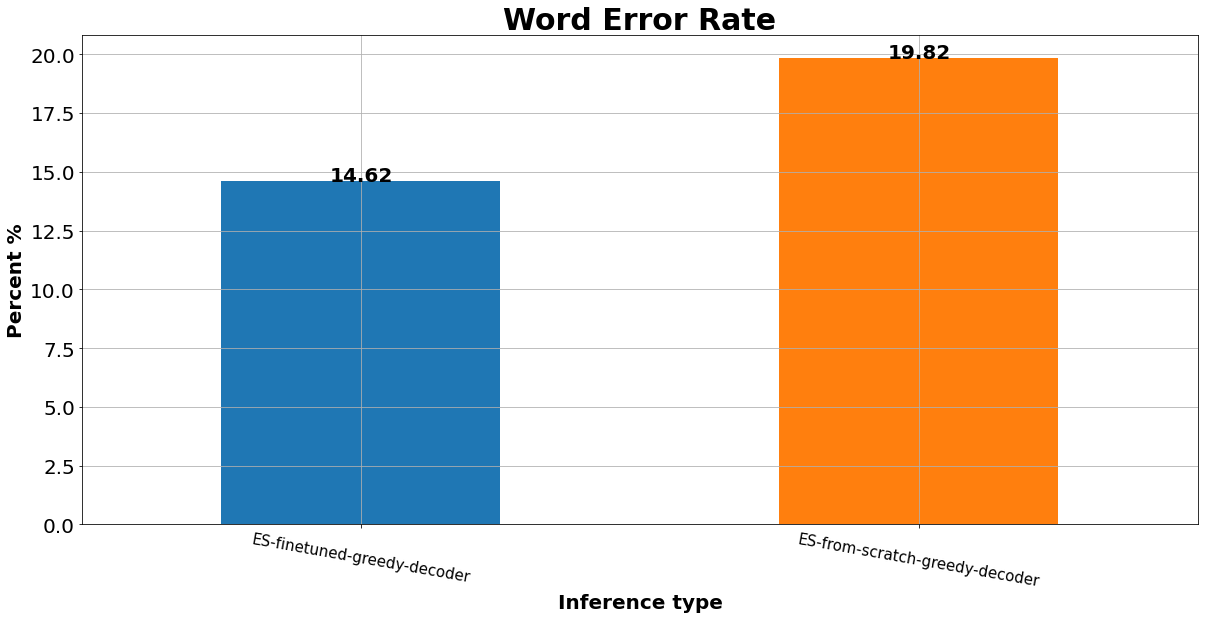

In [81]:
sel_inference = {'ES-finetuned-greedy-decoder': {'wer': 0.14623744136724615,
  'path': '/data/asr/results/inferences/English_to_Spanish/results-am_grid__dev__ES-finetuned-greedy-decoder.json',
  'lm_wer': None},
 'ES-from-scratch-greedy-decoder': {'wer': 0.19816709754322956,
  'path': '/data/asr/results/inferences/English_to_Spanish/results-am_grid__dev__ES-from-scratch-greedy-decoder.json',
  'lm_wer': None}}
sort_metric = 'percentWER'
lm_df = parse_manifest_wer(sel_inference, sort_metric=sort_metric)
lm_wer = barplot_manifest(lm_df,'percentWER',"Word Error Rate", "Inference type","Percent %")